<a href="https://colab.research.google.com/github/shengy90/MSc-Project/blob/master/notebooks/29th_July_Household_Level_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1️⃣ Setup Notebook 💻**


### **Authenticate with BigQuery ☁️**

In [ ]:
!pip install --upgrade google-cloud-bigquery[bqstorage,pandas]
!pip install --upgrade pandas-gbq

In [4]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [5]:
%%bigquery --project machine-learning-msc df --use_bqstorage_api
SELECT 
  COUNT(*) as total_rows
FROM `machine-learning-msc.low_carbon_london.household_consumption_daily_agg` 

In [6]:
df.head()

,total_rows
0,14841792


### **Importing Libraries⏬**

##### Standard Libraries

In [7]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
import random
import datetime as dt

from tqdm import tqdm
from datetime import date
from matplotlib.gridspec import GridSpec
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
 
sns.set()
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# **2️⃣ Household Pred**

### **Test**

In [14]:
%%bigquery --project machine-learning-msc df --use_bqstorage_api

WITH pca_clusters AS (
  SELECT 
  lcl_id,
  cluster
  FROM `machine-learning-msc.low_carbon_london.pca_clusters_20200712`
  WHERE train_test_split = 'test'
  GROUP BY 1,2
  ),
  
som_cluster_num AS (
  SELECT cluster_x, cluster_y,
  CAST(ROW_NUMBER() OVER (ORDER BY cluster_x, cluster_y)-1 AS STRING) AS cluster
  FROM `machine-learning-msc.low_carbon_london.som_clusters_20200712`
  group by 1,2
  order by 1,2 asc
  ),
  
som_clusters AS (
  SELECT 
  DISTINCT 
  a.lcl_id,
  b.cluster,
  a.cluster_x,
  a.cluster_y
  FROM `machine-learning-msc.low_carbon_london.som_clusters_20200712` a 
  LEFT JOIN som_cluster_num b ON a.cluster_x = b.cluster_x AND a.cluster_y = b.cluster_y
  WHERE train_test_split = 'test'
  )


SELECT 
pca.cluster AS pca_cluster,
som.cluster AS som_cluster,
test.lcl_id,
test.ts AS ds,
test.kwhh AS y,

-- baseline
baseline.yhat AS baseline_pred,
ROUND(ABS(SAFE_DIVIDE(baseline.yhat,kwhh+0.001) - 1),4)*100 AS baseline_abs_perc_err,
ROUND((SAFE_DIVIDE(baseline.yhat,kwhh+0.001) - 1),4)*100 AS baseline_perc_err,
-- pca 
pca_pred.yhat AS agglo_pred,
ROUND(ABS(SAFE_DIVIDE(pca_pred.yhat,kwhh+0.001) - 1),4)*100 AS agglo_abs_perc_err,
ROUND((SAFE_DIVIDE(pca_pred.yhat,kwhh+0.001) - 1),4)*100 AS agglo_perc_err,

-- som 
som_pred.yhat AS som_pred,
ROUND(ABS(SAFE_DIVIDE(som_pred.yhat,kwhh+0.001) - 1),4)*100 AS som_abs_perc_err,
ROUND((SAFE_DIVIDE(som_pred.yhat,kwhh+0.001) - 1),4)*100 AS som_perc_err


FROM `machine-learning-msc.forecasting_20200719.test_set` test

LEFT JOIN pca_clusters pca 
  ON pca.lcl_id = test.lcl_id 
LEFT JOIN som_clusters som 
  ON som.lcl_id = test.lcl_id
LEFT JOIN `machine-learning-msc.forecasting_20200719.agglo_test_prediction` pca_pred
  ON test.ts = pca_pred.ds
  AND pca_pred.cluster = pca.cluster
LEFT JOIN `machine-learning-msc.forecasting_20200719.som_test_prediction` som_pred
  ON test.ts = som_pred.ds
  AND som_pred.cluster = som.cluster
LEFT JOIN `machine-learning-msc.forecasting_20200719.baseline_test_prediction` baseline
  ON baseline.ds = test.ts 
  
WHERE test.ts >= '2013-02-01' AND test.ts < '2013-03-01'
ORDER BY 1,2,3,4 ASC 

In [15]:
df['ds'] = df['ds'].dt.tz_localize(None) # remove timezones 

In [10]:
print(f"Baseline Test Mape: {np.average(df['baseline_abs_perc_err'])}")
print(f"Agglomerative Clustering Test Mape: {np.average(df['agglo_abs_perc_err'])}")
print(f"SOM Clustering Test Mape: {np.average(df['som_abs_perc_err'])}")

Baseline Test Mape: 493.58294241934954
Agglomerative Clustering Test Mape: 1675.7211575404147
SOM Clustering Test Mape: 490.788862435771


In [16]:
print(f"Baseline Test Mean Percentage Error: {np.average(df['baseline_perc_err'])}")
print(f"Agglomerative Clustering Test Mean Percentage Error: {np.average(df['agglo_perc_err'])}")
print(f"SOM Clustering Test Mean Percentage Error: {np.average(df['som_perc_err'])}")

Baseline Test Mean Percentage Error: 469.82735556495936
Agglomerative Clustering Test Mean Percentage Error: 1661.0919225034045
SOM Clustering Test Mean Percentage Error: 453.4359002559122


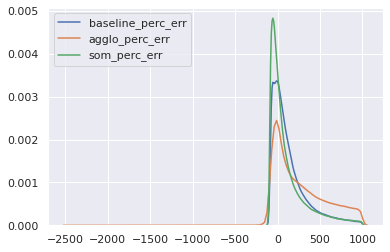

In [28]:
ax = sns.kdeplot(df.query("baseline_perc_err<1000")['baseline_perc_err'])
ax = sns.kdeplot(df.query("agglo_perc_err<1000")['agglo_perc_err'])
ax = sns.kdeplot(df.query("som_perc_err<1000")['som_perc_err'])